# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer() #HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./toxiccomments_train.csv', my_random_seed=15)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Ridege Regression with Different  Regularizations

In [83]:
# --- rdg_1: alpha=0.1 ---
rdg_1 = linear_model.RidgeClassifier(alpha=0.1)
rdg_1.fit(X_train, y_train)
rdg_performance_train_1 = BinaryClassificationPerformance(rdg_1.predict(X_train), y_train, 'rdg_alpha:1e-1')
rdg_performance_train_1.compute_measures()
print('alpha:1e-1', rdg_performance_train_1.performance_measures)

alpha:0.1 {'Pos': 13000, 'Neg': 114656, 'TP': 12138, 'TN': 114517, 'FP': 139, 'FN': 862, 'Accuracy': 0.992158613774519, 'Precision': 0.988678015801906, 'Recall': 0.9336923076923077, 'desc': 'rdg_alpha:0.1'}


In [84]:
# --- rdg_2: alpha=1 ---
rdg_2 = linear_model.RidgeClassifier(alpha=1)
rdg_2.fit(X_train, y_train)
rdg_performance_train_2 = BinaryClassificationPerformance(rdg_2.predict(X_train), y_train, 'rdg_alpha:1e0')
rdg_performance_train_2.compute_measures()
print('alpha:1e0', rdg_performance_train_2.performance_measures)

alpha:1e1 {'Pos': 13000, 'Neg': 114656, 'TP': 12139, 'TN': 114516, 'FP': 140, 'FN': 861, 'Accuracy': 0.992158613774519, 'Precision': 0.9885984200667807, 'Recall': 0.9337692307692308, 'desc': 'rdg_alpha:1e0'}


In [85]:
# --- rdg_3: alpha=10 ---
rdg_3 = linear_model.RidgeClassifier(alpha=1e1)
rdg_3.fit(X_train, y_train)
rdg_performance_train_3 = BinaryClassificationPerformance(rdg_3.predict(X_train), y_train, 'rdg_alpha:1e1')
rdg_performance_train_3.compute_measures()
print('alpha:1e1', rdg_performance_train_3.performance_measures)

alpha:1e1 {'Pos': 13000, 'Neg': 114656, 'TP': 12136, 'TN': 114518, 'FP': 138, 'FN': 864, 'Accuracy': 0.9921507802218462, 'Precision': 0.9887567215251751, 'Recall': 0.9335384615384615, 'desc': 'rdg_alpha:1e1'}


In [86]:
# --- rdg_4: alpha=100 ---
rdg_4 = linear_model.RidgeClassifier(alpha=1e2)
rdg_4.fit(X_train, y_train)
rdg_performance_train_4 = BinaryClassificationPerformance(rdg_4.predict(X_train), y_train, 'rdg_alpha:1e2')
rdg_performance_train_4.compute_measures()
print('alpha:1e2', rdg_performance_train_4.performance_measures)

alpha:1e2 {'Pos': 13000, 'Neg': 114656, 'TP': 12126, 'TN': 114519, 'FP': 137, 'FN': 874, 'Accuracy': 0.992080278247791, 'Precision': 0.9888281823371117, 'Recall': 0.9327692307692308, 'desc': 'rdg_alpha:1e2'}


In [87]:
# --- rdg_5: alpha=1000 ---
rdg_5 = linear_model.RidgeClassifier(alpha=1e3)
rdg_5.fit(X_train, y_train)
rdg_performance_train_5 = BinaryClassificationPerformance(rdg_5.predict(X_train), y_train, 'rdg_alpha:1e3')
rdg_performance_train_5.compute_measures()
print('alpha:1e3', rdg_performance_train_5.performance_measures)


alpha:1e3 {'Pos': 13000, 'Neg': 114656, 'TP': 12065, 'TN': 114521, 'FP': 135, 'FN': 935, 'Accuracy': 0.9916180986400952, 'Precision': 0.9889344262295082, 'Recall': 0.928076923076923, 'desc': 'rdg_alpha:1e3'}


In [88]:
# --- rdg_6: alpha=10000 ---
rdg_6 = linear_model.RidgeClassifier(alpha=1e4)
rdg_6.fit(X_train, y_train)
rdg_performance_train_6 = BinaryClassificationPerformance(rdg_6.predict(X_train), y_train, 'rdg_alpha:1e4')
rdg_performance_train_6.compute_measures()
print('alpha:1e4', rdg_performance_train_6.performance_measures)

alpha:1e4 {'Pos': 13000, 'Neg': 114656, 'TP': 11785, 'TN': 114540, 'FP': 116, 'FN': 1215, 'Accuracy': 0.9895735413924923, 'Precision': 0.9902529199226956, 'Recall': 0.9065384615384615, 'desc': 'rdg_alpha:1e4'}


In [89]:
# --- rdg_7: alpha=1e5 ---
rdg_7 = linear_model.RidgeClassifier(alpha=1e5)
rdg_7.fit(X_train, y_train)
rdg_performance_train_7 = BinaryClassificationPerformance(rdg_7.predict(X_train), y_train, 'rdg_alpha:1e5')
rdg_performance_train_7.compute_measures()
print('alpha:1e5', rdg_performance_train_7.performance_measures)

alpha:1e5 {'Pos': 13000, 'Neg': 114656, 'TP': 10026, 'TN': 114624, 'FP': 32, 'FN': 2974, 'Accuracy': 0.9764523406655387, 'Precision': 0.996818452972758, 'Recall': 0.7712307692307693, 'desc': 'rdg_alpha:1e5'}


In [90]:
# --- rdg_8: alpha=1e6 ---
rdg_8 = linear_model.RidgeClassifier(alpha=1e6)
rdg_8.fit(X_train, y_train)
rdg_performance_train_8 = BinaryClassificationPerformance(rdg_8.predict(X_train), y_train, 'rdg_alpha:1e6')
rdg_performance_train_8.compute_measures()
print('alpha:1e6', rdg_performance_train_8.performance_measures)

alpha:1e6 {'Pos': 13000, 'Neg': 114656, 'TP': 991, 'TN': 114655, 'FP': 1, 'FN': 12009, 'Accuracy': 0.9059190323995738, 'Precision': 0.998991935483871, 'Recall': 0.07623076923076923, 'desc': 'rdg_alpha:1e6'}


### ROC plot to compare performance of various models and fits

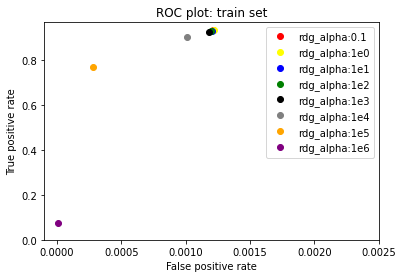

In [130]:
fits = [rdg_performance_train_1,rdg_performance_train_2, rdg_performance_train_3,rdg_performance_train_4,rdg_performance_train_5,rdg_performance_train_6,
       rdg_performance_train_7,rdg_performance_train_8]
colors = ['red','yellow','blue','green','black','gray','orange','purple']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([-0.0001, 0.0025, 0, 0.97])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


### let's look at some false positives:

In [47]:
rgd8_predictions = rdg_8.predict(X_train)

In [50]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rgd8_predictions)):
    if (rgd8_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
1415
Okay, I'm sorry, I didn't know that telling someone what I thought of them was abuse, I called him a coward and an idiot, and I just lost my rag because I believed that he'd unfairly blocked my friends, I'm sorry but we all lose our heads sometimes and I was just annoyed, please unblock me, if you do, can you give me the template which takes me to recent vandalism. Thanks
* * * * * * * * * 
4623
In really nasty cases, these things can take years to kill.
* * * * * * * * * 
57227
what's with the weird conspiracy theory crap?
* * * * * * * * * 
65251
(I'm talking on the lesbian and vagina article, not the talk page)
* * * * * * * * * 
83162
Why are you here? Is this random or did I piss you off somehow?
* * * * * * * * * 
88871
Do you really hate me?
* * * * * * * * * 
89761
Holding Jews to higher standards than Arabs is racist. Do you think Arabs are inferior to Jews?
* * * * * * * * * 
112618
Not at this time, fag.
* * * * * * * * * 
113688
Fat ==
LAUR

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: Ridge Regression Classifier

In [115]:
rdg_performance_test_1 = BinaryClassificationPerformance(rdg_1.predict(X_test), y_test, 'rdg_alpha:0.1')
rdg_performance_test_1.compute_measures()
print(rdg_performance_test_1.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1815, 'TN': 26931, 'FP': 1759, 'FN': 1410, 'Accuracy': 0.9007049976500079, 'Precision': 0.5078343592613318, 'Recall': 0.5627906976744186, 'desc': 'rdg_alpha:0.1'}


In [107]:
rdg_performance_test_2 = BinaryClassificationPerformance(rdg_2.predict(X_test), y_test, 'rdg_alpha:1')
rdg_performance_test_2.compute_measures()
print(rdg_performance_test_2.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1816, 'TN': 26938, 'FP': 1752, 'FN': 1409, 'Accuracy': 0.9009556634811218, 'Precision': 0.5089686098654709, 'Recall': 0.5631007751937984, 'desc': 'rdg_alpha:1'}


In [108]:
rdg_performance_test_3 = BinaryClassificationPerformance(rdg_3.predict(X_test), y_test, 'rdg_alpha:10')
rdg_performance_test_3.compute_measures()
print(rdg_performance_test_3.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1821, 'TN': 26995, 'FP': 1695, 'FN': 1404, 'Accuracy': 0.9028983236722544, 'Precision': 0.5179180887372014, 'Recall': 0.5646511627906977, 'desc': 'rdg_alpha:10'}


In [109]:
rdg_performance_test_4 = BinaryClassificationPerformance(rdg_4.predict(X_test), y_test, 'rdg_alpha:1e2')
rdg_performance_test_4.compute_measures()
print(rdg_performance_test_4.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1814, 'TN': 27171, 'FP': 1519, 'FN': 1411, 'Accuracy': 0.9081936393545355, 'Precision': 0.5442544254425442, 'Recall': 0.5624806201550387, 'desc': 'rdg_alpha:1e2'}


In [110]:
rdg_performance_test_5 = BinaryClassificationPerformance(rdg_5.predict(X_test), y_test, 'rdg_alpha:1e3')
rdg_performance_test_5.compute_measures()
print(rdg_performance_test_5.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1789, 'TN': 27706, 'FP': 984, 'FN': 1436, 'Accuracy': 0.9241735860880463, 'Precision': 0.6451496574107465, 'Recall': 0.5547286821705426, 'desc': 'rdg_alpha:1e3'}


In [111]:
rdg_performance_test_6 = BinaryClassificationPerformance(rdg_6.predict(X_test), y_test, 'rdg_alpha:1e4')
rdg_performance_test_6.compute_measures()
print(rdg_performance_test_6.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1721, 'TN': 28234, 'FP': 456, 'FN': 1504, 'Accuracy': 0.9385868713770954, 'Precision': 0.7905374368396877, 'Recall': 0.5336434108527132, 'desc': 'rdg_alpha:1e4'}


In [112]:
rdg_performance_test_7 = BinaryClassificationPerformance(rdg_7.predict(X_test), y_test, 'rdg_alpha:1e5')
rdg_performance_test_7.compute_measures()
print(rdg_performance_test_7.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1295, 'TN': 28613, 'FP': 77, 'FN': 1930, 'Accuracy': 0.9371142096193013, 'Precision': 0.9438775510204082, 'Recall': 0.4015503875968992, 'desc': 'rdg_alpha:1e5'}


In [113]:
rdg_performance_test_8 = BinaryClassificationPerformance(rdg_8.predict(X_test), y_test, 'rdg_alpha:1e6')
rdg_performance_test_8.compute_measures()
print(rdg_performance_test_8.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 78, 'TN': 28690, 'FP': 0, 'FN': 3147, 'Accuracy': 0.901394328685571, 'Precision': 1.0, 'Recall': 0.024186046511627906, 'desc': 'rdg_alpha:1e6'}


### ROC plot to compare performance of various models and fits

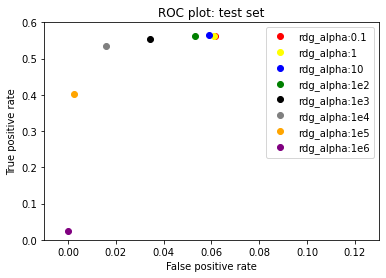

In [128]:
fits = [rdg_performance_test_1, rdg_performance_test_2, rdg_performance_test_3,rdg_performance_test_4,rdg_performance_test_5,rdg_performance_test_6,
       rdg_performance_test_7,rdg_performance_test_8]
colors = ['red','yellow','blue','green','black','gray','orange','purple']


for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([-0.01, 0.13, 0.0, 0.6])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()